# Import libraries (Nhập thư viện)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from sklearn import metrics
from tqdm.notebook import tqdm, trange

import copy
import time
import random
import numpy as np
import matplotlib.pyplot as plt

# Set the random seed for Python, Numpy and PyTorch (Đặt hạt giống ngẫu nhiên cho Python, Numpy và PyTorch)

In [ ]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.detreministic = True

In [ ]:
ROOT = '.data'

train_data = datasets.FashionMNIST(root=ROOT,
                                   download=True,
                                   train=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 13414110.34it/s]


Extracting .data/FashionMNIST/raw/train-images-idx3-ubyte.gz to .data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 231141.72it/s]


Extracting .data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to .data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3988076.84it/s]


Extracting .data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to .data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16842649.76it/s]

Extracting .data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to .data/FashionMNIST/raw



# Calculate mean and std based on dataset (Tính toán giá trị trung bình và độ lệch chuẩn dựa trên tập dữ liệu)

In [ ]:
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

In [ ]:
print('Calculated mean {}'.format(mean))
print('Calculated std {}'.format(std))

Calculated mean 0.28604060411453247
Calculated std 0.35302427411079407


# Data Augmentation (Tăng cường dữ liệu)

In [ ]:
train_transforms = transforms.Compose([
                                transforms.RandomRotation(5, fill=(0,)),
                                transforms.RandomCrop(28, padding=1),
                                transforms.RandomHorizontalFlip(p=0.06),
                                transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
                                transforms.RandomAffine(degrees=5, shear=2),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[mean], std=[std])
                            ])

test_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[mean], std=[std])
                            ])

In [ ]:
train_data = datasets.FashionMNIST(root=ROOT,
                                   download=True,
                                   train=True,
                                   transform=train_transforms)

test_data = datasets.FashionMNIST(root=ROOT,
                                  download=True,
                                  train=False,
                                  transform=test_transforms)

In [ ]:
print(f'Number of training samples : {len(train_data)}')
print(f'Number of testing samples : {len(test_data)}')

Number of training samples : 60000
Number of testing samples : 10000


# Data Visualization

In [ ]:
def plot_images(imgs):

    n_images = len(imgs)

    rows = int(np.sqrt(n_images))
    columns = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(10, 10))
    for i in range(rows * columns):
        ax = fig.add_subplot(rows, columns, i+1)
        ax.imshow(imgs[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

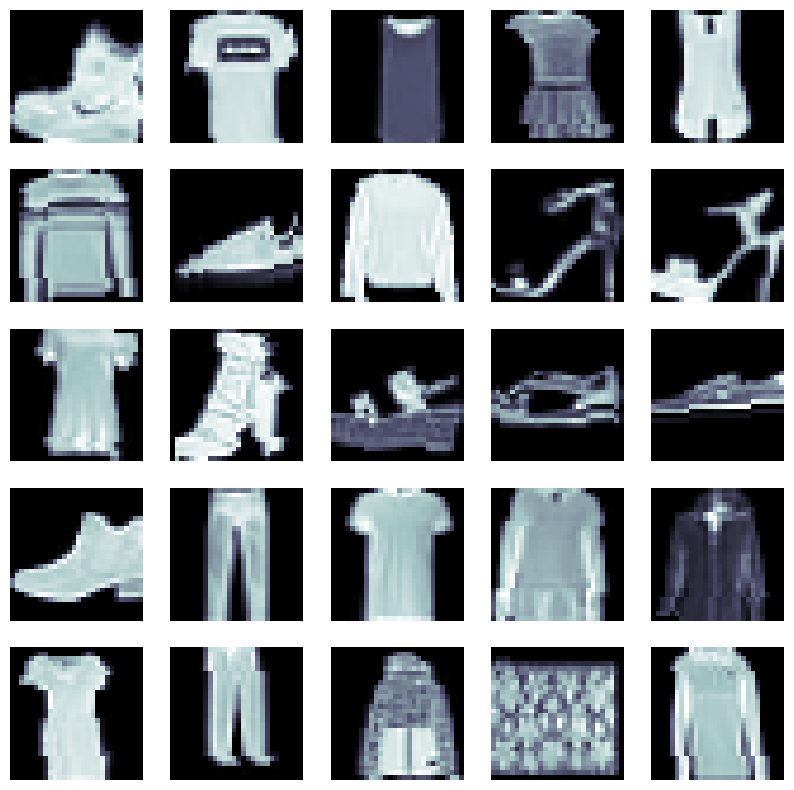

In [ ]:
N_IMAGES = 25

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]

plot_images(images)

In [ ]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

In [ ]:
train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


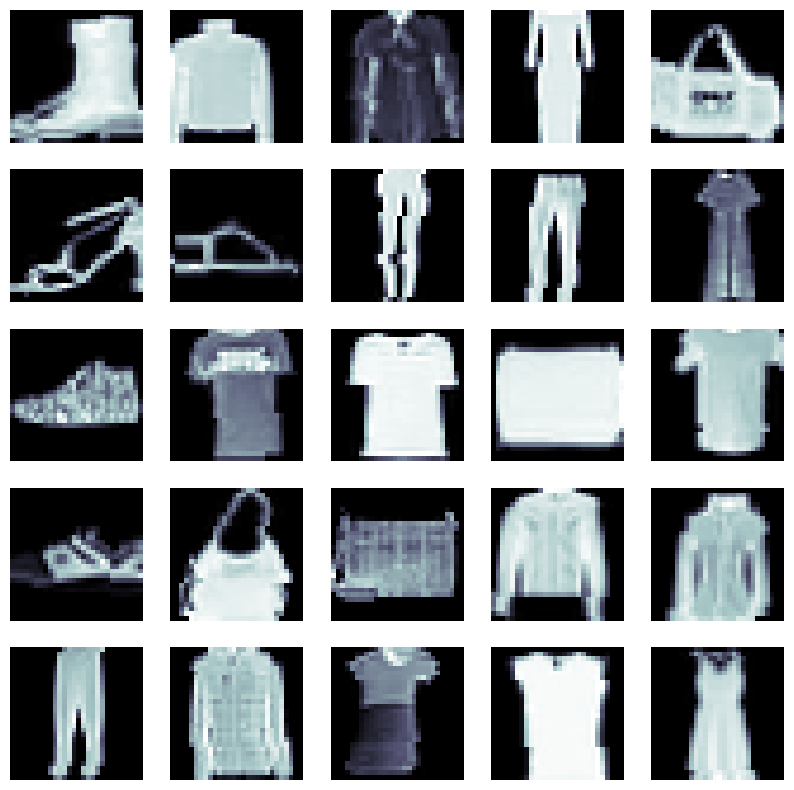

In [ ]:
N_IMAGES = 25

images = [image for image, label in [valid_data[i] for i in range(N_IMAGES)]]

plot_images(images)

In [ ]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

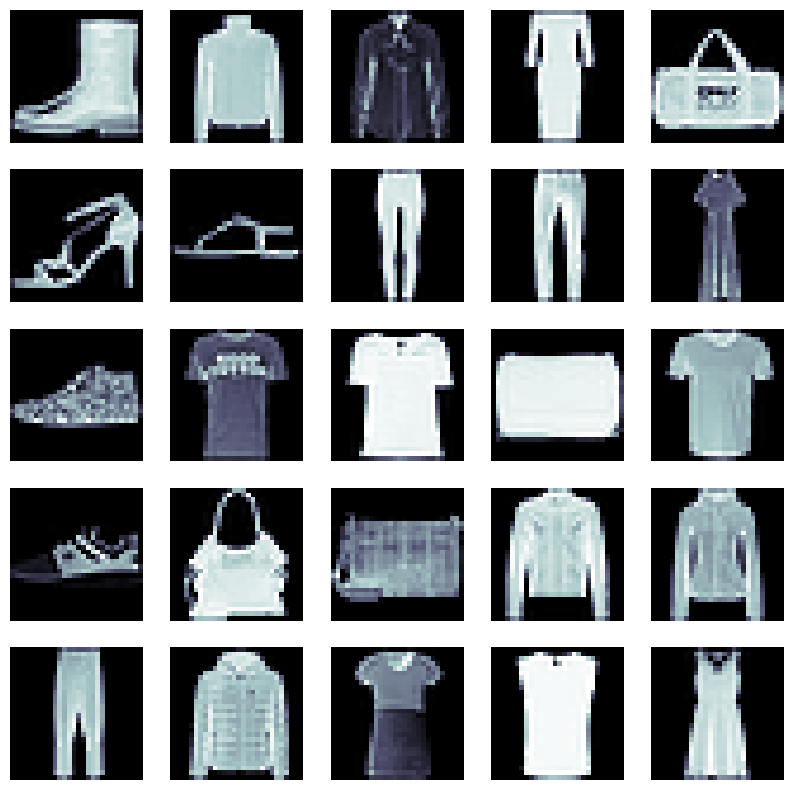

In [ ]:
N_IMAGES = 25

images = [image for image, label in [valid_data[i] for i in range(N_IMAGES)]]

plot_images(images)

# Set the Batch Size and get types of dataset to DataLoader

In [ ]:
BATCH_SIZE = 256

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

# Define the model

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        # Define the first convolutional layer (Xác định lớp tích chập đầu tiên)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)

        # Define the second convolutional layer (Xác định lớp tích chập thứ hai)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Define the batch normalization (Xác định chuẩn hóa theo lô)
        self.batch_norm1 = nn.BatchNorm2d(num_features=32)
        self.batch_norm2 = nn.BatchNorm2d(num_features=64)

        # Define the fully connected layers (Xác định các lớp được kết nối đầy đủ)
        self.fc1 = nn.Linear(in_features=64*7*7, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

        # Define the max pooling layer (Xác định lớp nhóm tối đa)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        # Pass the input through the first convolutional layer followed by batch normalization, ReLU activation and pooling
        # Truyền đầu vào qua lớp tích chập đầu tiên theo sau là chuẩn hóa hàng loạt, kích hoạt ReLU và gộp nhóm
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))

        # Pass the result through the second convolutional layer followed by batch normalization, ReLU activation and pooling
        # Truyền kết quả qua lớp tích chập thứ hai theo sau là chuẩn hóa hàng loạt, kích hoạt ReLU và gộp nhóm
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))

        # Flatten the tensor into a vector (Làm phẳng tenxơ thành một vectơ)
        x = x.view(x.size(0), -1)  # Flatten the tensor while preserving batch size (Làm phẳng tensor trong khi vẫn giữ nguyên kích thước lô)

        # Pass the flattened tensor through the first fully connected layer followed by ReLU activation
        # Truyền vectơ được làm phẳng qua lớp được kết nối đầy đủ đầu tiên theo sau là kích hoạt ReLU
        h = F.relu(self.fc1(x))

        # Pass the result through the second fully connected layer to get the final output
        # Truyền kết quả qua lớp được kết nối đầy đủ thứ hai để có đầu ra cuối cùng
        x = self.fc2(h)

        return x, h

In [ ]:
model = MLP()

# Count the parameters

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 421,834 trainable parameters


# Using optimizer Adam and the Loss function CrossEntropyLoss

In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
model = model.to(device)
criterion = criterion.to(device)

# Prepare some functions and ready to train

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Train the model

In [ ]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Training:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 14s
	Train Loss: 0.617 | Train Acc: 77.42%
	 Val. Loss: 0.400 |  Val. Acc: 85.30%


Training:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 52s
	Train Loss: 0.445 | Train Acc: 83.50%
	 Val. Loss: 0.329 |  Val. Acc: 88.05%


Training:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 1m 17s
	Train Loss: 0.396 | Train Acc: 85.25%
	 Val. Loss: 0.299 |  Val. Acc: 88.96%


Training:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 51s
	Train Loss: 0.376 | Train Acc: 86.15%
	 Val. Loss: 0.291 |  Val. Acc: 89.40%


Training:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 53s
	Train Loss: 0.354 | Train Acc: 86.71%
	 Val. Loss: 0.280 |  Val. Acc: 89.58%


Training:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 52s
	Train Loss: 0.334 | Train Acc: 87.57%
	 Val. Loss: 0.281 |  Val. Acc: 89.89%


Training:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 52s
	Train Loss: 0.331 | Train Acc: 87.54%
	 Val. Loss: 0.256 |  Val. Acc: 90.67%


Training:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 52s
	Train Loss: 0.316 | Train Acc: 88.08%
	 Val. Loss: 0.286 |  Val. Acc: 89.41%


Training:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 50s
	Train Loss: 0.309 | Train Acc: 88.46%
	 Val. Loss: 0.250 |  Val. Acc: 90.70%


Training:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 49s
	Train Loss: 0.300 | Train Acc: 88.76%
	 Val. Loss: 0.262 |  Val. Acc: 90.41%


## Load the model

In [ ]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

## Test the model

In [ ]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.264 | Test Acc: 90.55%


# Get prediction and plot confusion matrix (Nhận dự đoán và vẽ ma trận nhầm lẫn)

In [ ]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

In [ ]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

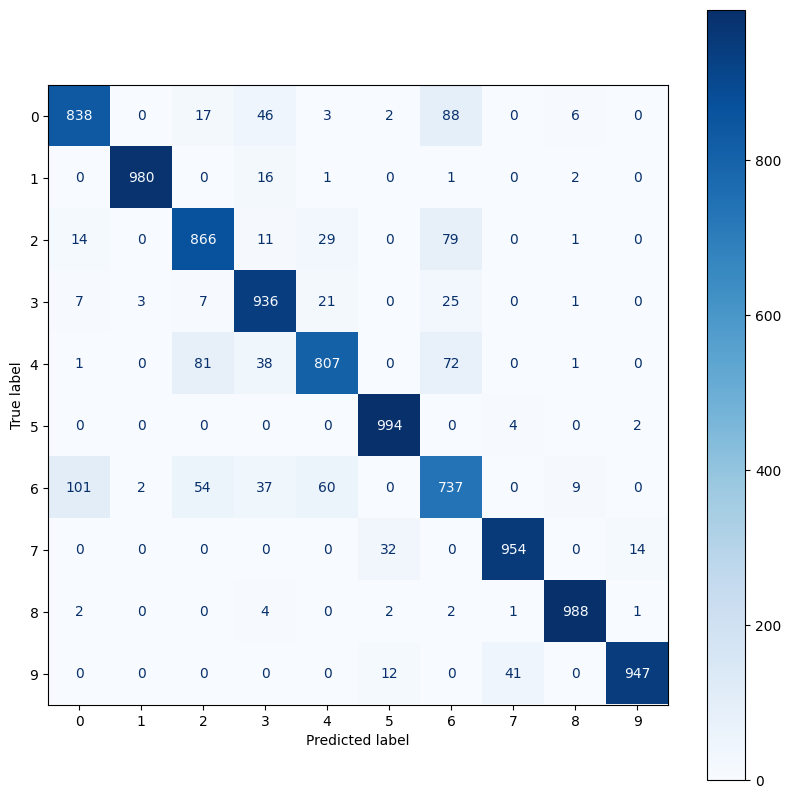

In [ ]:
plot_confusion_matrix(labels, pred_labels)

# Get all incorrect images and show few incorrect images (Lấy tất cả hình ảnh không chính xác và hiển thị một số hình ảnh không chính xác)

In [ ]:
corrects = torch.eq(labels, pred_labels)

In [ ]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

In [ ]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(25, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)

        # Lấy nhãn chữ dựa trên chỉ số nhãn số (Get text label based on numeric label index)
        true_label_text = classes[true_label]
        incorrect_label_text = classes[incorrect_label.item()]

        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'True label: {true_label_text} ({true_label}) ({true_prob:.3f})\n'
                     f'Pred label: {incorrect_label_text} ({incorrect_label}) ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

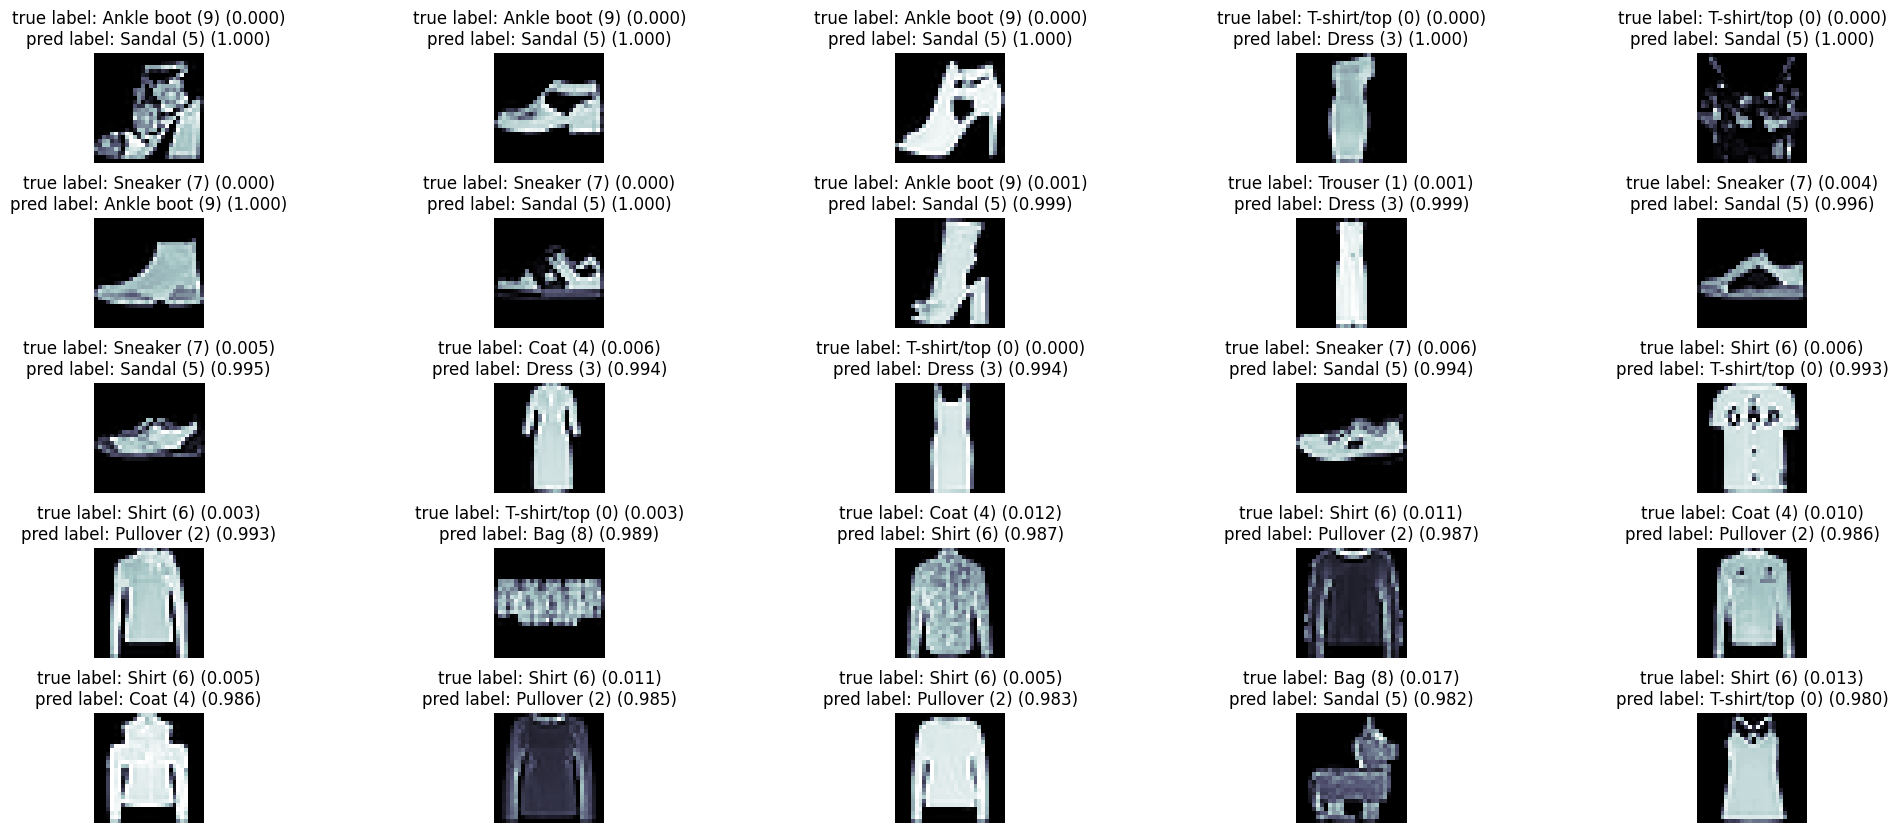

In [ ]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)